# Probit regression

Testing probit regression with identity covariance

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from time import time

import cvxpy as cv
from statsmodels.discrete.discrete_model import Probit
import sklearn.linear_model as linear_model
from scipy.special import erfcinv

from state_evolution.models.probit_regression import ProbitRegression # logistic regression task
from state_evolution.models.logistic_regression import LogisticRegression # logistic regression task
from state_evolution.models.bayes_optimal_probit import BayesOptimalProbit
from state_evolution.algorithms.state_evolution import StateEvolution # Standard SP iteration
from state_evolution.auxiliary.utility import *
from state_evolution.data_models.custom import Custom # Custom data model. You input the covariances

sys.path.append('../overparametrized-uncertainty/Code/')
import core.data as data


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
d = 512

# Covariances

Omega = Psi = Phi = np.eye(d)

# Teacher weights
theta = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d))
# NORMALIZE THE TEACHER FOR BETTER RESULTS

In [61]:
alpha   = 10.0
sigma   = 0.0
lambda_ = 0.1

w0, X, y = data.ProbitModelData(covariance = Omega, teacher_covariance = np.eye(d), sigma = sigma).sample_instance(alpha)

data_model = Custom(teacher_teacher_cov = Psi,
                    student_student_cov = Omega,
                    teacher_student_cov = Phi,
                    teacher_weights     = w0)

In [62]:
task = ProbitRegression(sample_complexity = alpha,
                        regularisation    = lambda_,
                        data_model        = data_model,
                        Delta             = sigma**2)

sp = StateEvolution(model = task,
                    initialisation = 'uninformed',
                    tolerance = 1e-7,
                    damping = 0.5,
                    verbose = True,
                    max_steps = 1000)

sp.iterate()

t: 0, diff: 48.41300614885706, self overlaps: 0.5863063245288528, teacher-student overlap: 0.47998635720092453
t: 1, diff: 25.357185452009066, self overlaps: 1.204502215472863, teacher-student overlap: 0.8471249898310593
t: 2, diff: 13.684662119086617, self overlaps: 1.8506869319685055, teacher-student overlap: 1.1419976483204501
t: 3, diff: 7.704675186295692, self overlaps: 2.543137435615174, teacher-student overlap: 1.395440804878592
t: 4, diff: 4.684850726723081, self overlaps: 3.3585222454456836, teacher-student overlap: 1.6397715511354467
t: 5, diff: 3.285079286124981, self overlaps: 4.420219641249066, teacher-student overlap: 1.9045156363471172
t: 6, diff: 2.8310224823979753, self overlaps: 5.885380827873297, teacher-student overlap: 2.212692111141565
t: 7, diff: 2.968616623919432, self overlaps: 7.928070042378604, teacher-student overlap: 2.578217245142627
t: 8, diff: 3.4827125103224854, self overlaps: 10.70664369318694, teacher-student overlap: 3.0040011811731855
t: 9, diff: 4.

t: 74, diff: 1.7987820166709412e-06, self overlaps: 37.46380005755182, teacher-student overlap: 5.773636100308581
t: 75, diff: 1.2776806586067835e-06, self overlaps: 37.46380119696762, teacher-student overlap: 5.773636188704636
t: 76, diff: 8.105966669003095e-07, self overlaps: 37.46380191159042, teacher-student overlap: 5.773636244235979
t: 77, diff: 5.144091554942776e-07, self overlaps: 37.4638023604346, teacher-student overlap: 5.773636279228788
t: 78, diff: 2.6369738082010485e-07, self overlaps: 37.46380258364848, teacher-student overlap: 5.773636296671391
t: 79, diff: 1.3093063255809056e-07, self overlaps: 37.46380269064642, teacher-student overlap: 5.773636305185126
t: 80, diff: 8.696456976764466e-08, self overlaps: 37.46380261953405, teacher-student overlap: 5.773636299849108
Saddle point equations converged with t=81 iterations


In [63]:
# empirical probit 

w = cv.Variable(d)
error = - cv.sum(cv.log_normcdf( cv.multiply(y, X @ w))) + lambda_ / 2 * cv.sum_squares(w)
obj = cv.Minimize(error)
prob = cv.Problem(obj)
prob.solve()

weight = w.value

In [64]:
print('For PROBIT : ')

info = sp.get_info()
print('Info of state evolution : ', info)
print('theory : q = ', info['overlaps']['self_overlap'],', m = ', info['overlaps']['teacher_student'])

exp_q   = np.mean(weight * weight)
exp_m   = np.mean(weight * w0)
exp_rho = np.mean(w0 * w0)
print(f'experiment : q = {exp_q}, m = {exp_m}')
print('theoretical angle : ', info['overlaps']['teacher_student'] / (np.sqrt(info['overlaps']['self_overlap'])))
print('experimental angle : ', exp_m / np.sqrt(exp_q * exp_rho))

For PROBIT : 
Info of state evolution :  {'hyperparameters': {'initialisation': 'uninformed', 'damping': 0.5, 'max_steps': 1000, 'tolerance': 1e-07}, 'status': 1, 'convergence_time': 81, 'test_error': 0.04543069965298843, 'overlaps': {'variance': 1.8080613494533697, 'self_overlap': 37.46380269064642, 'teacher_student': 5.773636305185126}, 'test_loss': 0.1289893420935478, 'train_loss': 0.04089717070989968, 'calibration': -1.0}
theory : q =  37.46380269064642 , m =  5.773636305185126
experiment : q = 10.90211054369019, m = 3.1089437085460645
theoretical angle :  0.9432862294342347
experimental angle :  0.9880424582172654


In [65]:
lr_lambda_ = lambda_

lr_task = LogisticRegression(sample_complexity = alpha,
                        regularisation    = lr_lambda_,
                        data_model        = data_model,
                        Delta             = sigma**2)

lr_sp = StateEvolution(model = lr_task,
                    initialisation = 'uninformed',
                    tolerance = 1e-7,
                    damping = 0.5,
                    verbose = False,
                    max_steps = 1000)
lr_sp.iterate()

if lr_lambda_ > 0.0:
    lr = linear_model.LogisticRegression('l2', C=1. / lr_lambda_, fit_intercept=False)
else:
    lr = linear_model.LogisticRegression('none', fit_intercept=False)
lr.fit(X, y)

LogisticRegression(C=10.0, fit_intercept=False)

In [66]:
print('====')
print('For LOGISTIC')

lr_info = lr_sp.get_info()
print('theory : q = ', lr_info['overlaps']['self_overlap'],', m = ', lr_info['overlaps']['teacher_student'])
exp_q = np.mean(lr.coef_ * lr.coef_)
exp_m = np.mean(w0 * lr.coef_)
print(f'experiment : q = {exp_q}, m = {exp_m}')

print('theoretical angle : ', lr_info['overlaps']['teacher_student'] / (np.sqrt(lr_info['overlaps']['self_overlap'])))
print('experimental angle : ', exp_m / np.sqrt(exp_q))

====
For LOGISTIC
theory : q =  14.35227448715674 , m =  3.5518005784561923
experiment : q = 14.456916085441291, m = 3.5707769019455364
theoretical angle :  0.937536550080261
experimental angle :  0.9391282109288417


### Running as a function of alpha 

Fix the level, compute the calibration

In [111]:
p = 0.75
inv_p = - np.sqrt(2) * erfcinv(2 * p)

alpha_range  = np.linspace(10.0, 1000.0, 20)
calibrations = []

for alpha in alpha_range:
    print(alpha)
    task = ProbitRegression(sample_complexity = alpha,
                            regularisation    = 0.0,
                            data_model        = data_model,
                            Delta             = sigma**2)

    sp = StateEvolution(model = task,
                        initialisation = 'uninformed',
                        tolerance = 1e-7,
                        damping = 0.5,
                        verbose = False,
                        max_steps = 1000)

    sp.iterate()
    info = sp.get_info()
    
    m, q, rho = info['overlaps']['teacher_student'], info['overlaps']['self_overlap'], 1.0
    print(f'm = {m}, q = {q}, angle = {m / np.sqrt(q)}')
    calibrations.append(
         0.5 * erfc(- (m / q * inv_p) / np.sqrt(2*(rho - m**2 / q + sigma**2)))
    )
    print('Calibration : ', calibrations[-1])

10.0


/Users/clarte/Code/GCMProject/state_evolution/auxiliary/probit_integrals.py:19: RuntimeWarning: divide by zero encountered in log
  return - np.log(cdf(z))
/Users/clarte/anaconda3/envs/ml/lib/python3.9/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


m = 17.518558000798812, q = 400.12780941277646, angle = 0.8757879937783819
Calibration :  0.5169466114737635
62.10526315789474
m = 25.69406499603228, q = 926.9960777430069, angle = 0.8439056025270398
Calibration :  0.5101688884941326
114.21052631578948
m = 12.241209751920792, q = 185.75250146079594, angle = 0.898166813298956
Calibration :  0.5266137143411115
166.31578947368422
m = 13.293050220515795, q = 222.17264582920268, angle = 0.8918244034242699
Calibration :  0.5238628342759093
218.42105263157896
m = 13.91934623398257, q = 245.55495903203476, angle = 0.8882689536710787
Calibration :  0.522453592682079
270.5263157894737
m = 14.334356468900083, q = 261.7511041068463, angle = 0.8860004433976055
Calibration :  0.5215990567476354
322.63157894736844
m = 14.629415699392823, q = 273.6076541722445, angle = 0.8844287657041191
Calibration :  0.521026134998451
374.7368421052632
m = 14.849906418894726, q = 282.6535536167364, angle = 0.8832761255464706
Calibration :  0.520615505769896
426.8421

### Some plots

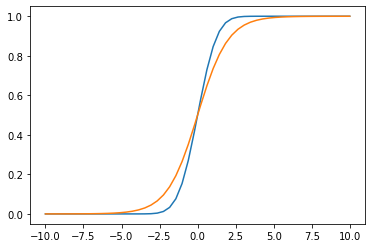

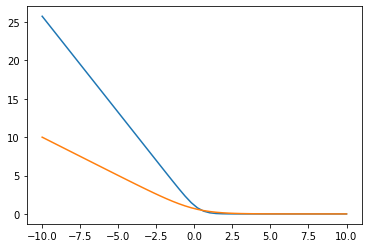

In [13]:
vals = np.linspace(-10.0, 10.0, 50)

def cdf(x):
    return 0.5 * erfc(- x / np.sqrt(2.0))

def approx_cdf(z):
    return 1.0 / (1.0 + 2*np.exp(-np.sqrt(2*np.pi)*z))

def logistic(x):
    return 1. / (1 + np.exp(-x))

def f_0(z):
    return np.log(1.0 + 2*np.exp(-np.sqrt(2*np.pi)*z))

def f_1(z):
    return np.log(1 + np.exp(-z))

plt.plot(vals, cdf(vals))
plt.plot(vals, logistic(vals))
plt.show()

plt.plot(vals, f_0(vals))
plt.plot(vals, f_1(vals))
plt.show()

nan 4.56986530030502


/var/folders/bh/679xzk357893hjh_yn8vw93h0000gq/T/ipykernel_47466/1727832809.py:14: RuntimeWarning: invalid value encountered in double_scalars
  return (x - omega) / V - y * gaussian(x) / cdf(x * y)
/var/folders/bh/679xzk357893hjh_yn8vw93h0000gq/T/ipykernel_47466/1727832809.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return 1. / V -  y * (- x * gaussian(x) / cdf(x * y) - y * gaussian(x)**2 / cdf(x * y)**2)


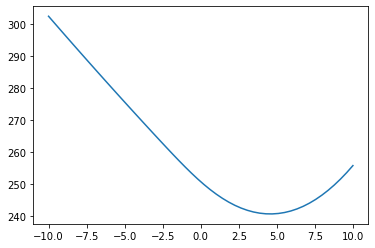

In [64]:
def gaussian(x, mean=0, var=1):
    return np.exp(-.5 * (x-mean)**2/var) / np.sqrt(2*np.pi*var)

def cdf(x):
    return 0.5 * erfc(- x / np.sqrt(2.0))

def loss(z):
    return - np.log( cdf(z) )

def moreau_loss(x, y, omega,V):
    return (x-omega)**2/(2*V) + loss(y*x)

def moreau_prime(x, y, omega, V):
        return (x - omega) / V - y * gaussian(x) / cdf(x * y)

def moreau_second(x, y, omega, V):
    return 1. / V -  y * (- x * gaussian(x) / cdf(x * y) - y * gaussian(x)**2 / cdf(x * y)**2)


omega = 100.0
V = 20.0
y = -1.0

root = root_scalar(lambda x : moreau_prime(x, y, omega, V),
                         fprime = lambda x : moreau_second(x, y, omega, V),
                         x0 = omega).root
mini = minimize_scalar(lambda x: moreau_loss(x, y, omega, V))['x']

plt.plot(vals, moreau_loss(vals, y, omega, V))

print(root, mini)